In [1]:
# imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
from skimage.measure import label, regionprops
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet34, resnet50
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.transform import GeneralizedRCNNTransform
from torchvision.ops import MultiScaleRoIAlign
from torchvision.transforms import functional

# Question 2

## Mask to Box Functions

In [2]:
def get_coordinates(mask):
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY)
    
    labels = label(mask)
    props = regionprops(labels)
    coords = []
    for prop in props:
        box = prop.bbox
        coords.append([box[1], box[0], box[3], box[2]])
    return coords

In [3]:
def masks_to_boxes(mask):
    coords = get_coordinates(mask)
    bbox_image = np.zeros_like(mask)
    for coord in coords:
        cv2.rectangle(bbox_image, (coord[0], coord[1]), (coord[2], coord[3]), (255, 0, 0), 2)
    return bbox_image

## Visualization Functions

In [4]:
def box_on_image_viz(image, bbox, axs):
    combined_image = cv2.addWeighted(image, 0.5, bbox, 0.9, 0)
    axs.imshow(combined_image)
    axs.set_title('Bounding Box on Image')

In [5]:
def box_on_mask_viz(mask, bbox, axs):
    combined_mask = cv2.addWeighted(mask, 0.5, bbox, 0.9, 0)
    axs.imshow(combined_mask)
    axs.set_title('Bounding Box on Mask')

In [6]:
def mask_and_box_viz(mask, bbox, laxs, raxs):
    laxs.imshow(mask)
    laxs.set_title("Mask")
    raxs.imshow(bbox)
    raxs.set_title("Bounding Boxes")

In [7]:
def visualize_image_mask_bbox(img, mask):
    fig, axs = plt.subplots(1, 4, figsize=(12, 6))
    bbox = masks_to_boxes(mask)
    box_on_image_viz(img, bbox, axs[0])
    box_on_mask_viz(mask, bbox, axs[1])
    mask_and_box_viz(mask, bbox, axs[2], axs[3])
    plt.show()

## Dataset Visualizations

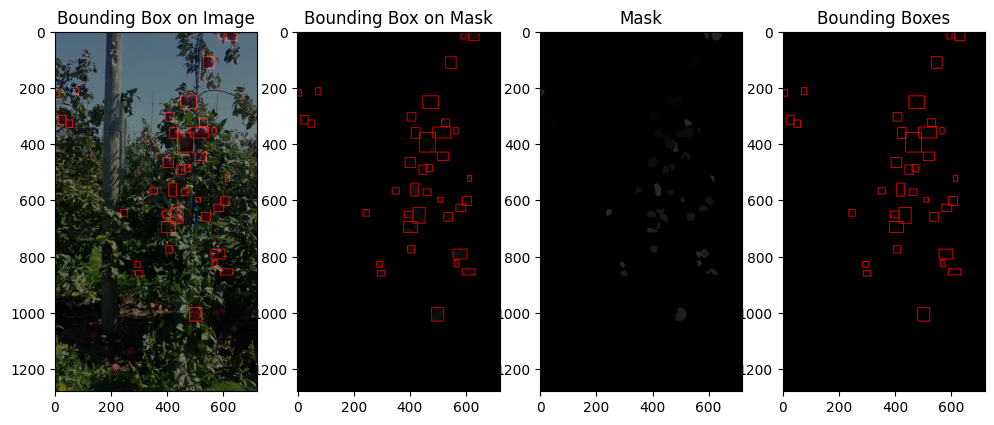

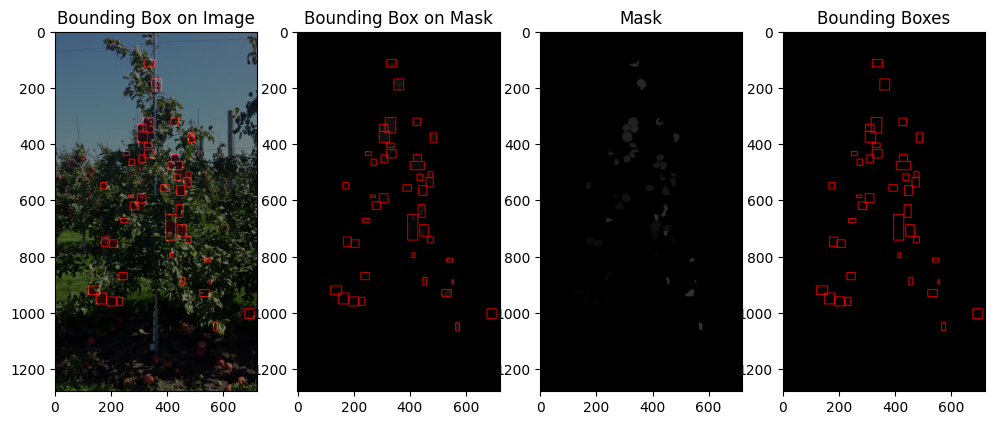

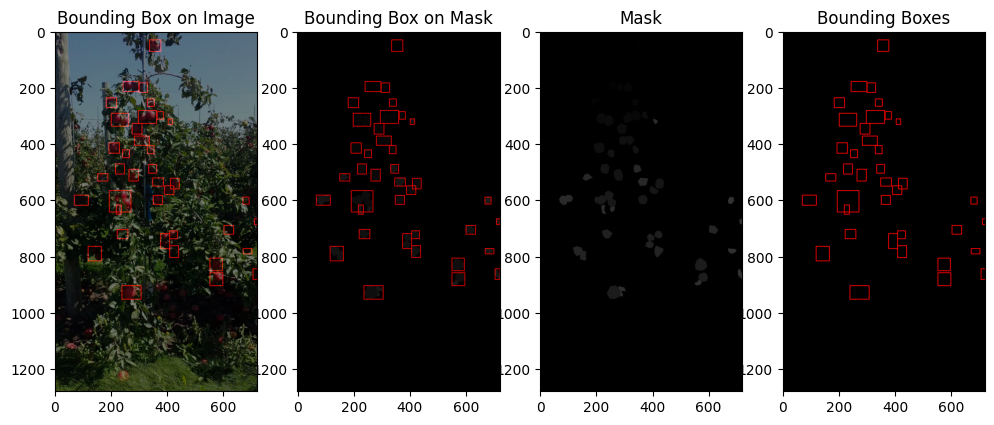

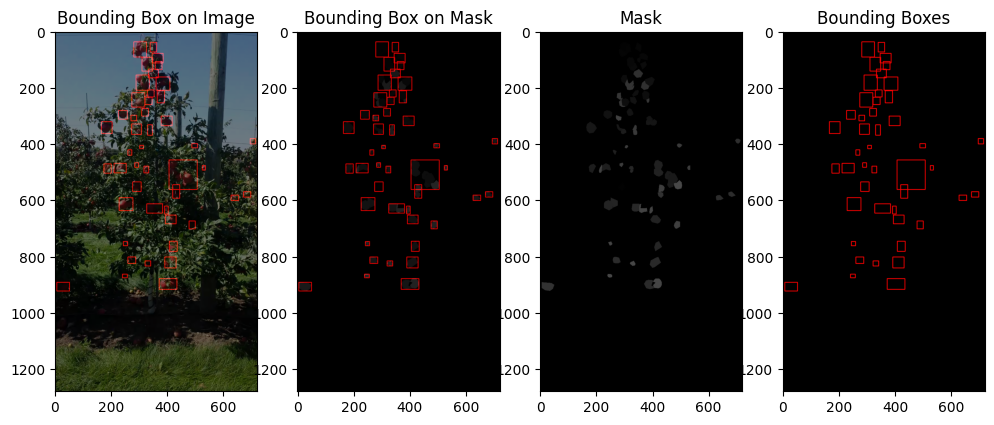

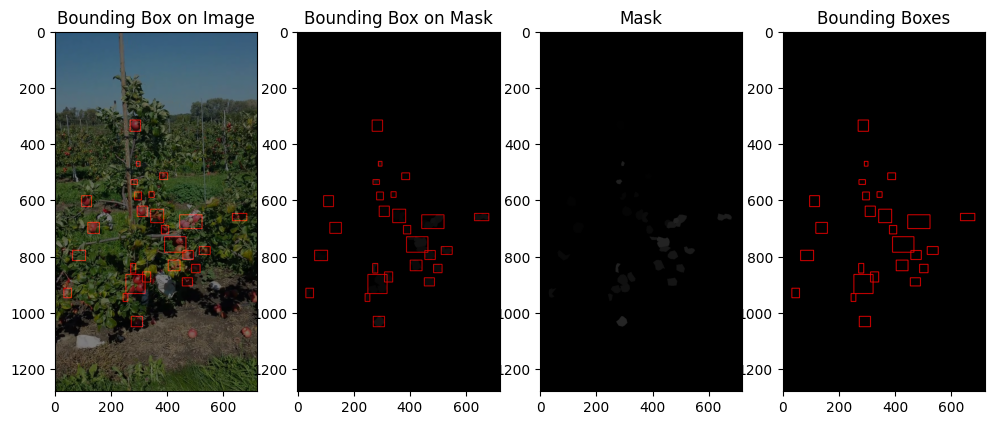

In [15]:
all_imgs = sorted(os.listdir("datasets/train/masks/"))
viz_imgs = []
for i in range(5):
    cur_img = np.random.choice(all_imgs)
    mask_path = "datasets/train/masks/" + cur_img
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    img_path = "datasets/train/images/" + cur_img
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    visualize_image_mask_bbox(img, mask)

## Data Split

In [16]:
imgs = []
masks = []
dataset_path = "datasets/train/"
dirs = sorted(os.listdir(dataset_path))
dir_masks = sorted([dataset_path + "masks/" + f for f in os.listdir(os.path.join(dataset_path, "masks/"))])
dir_imgs = sorted([dataset_path + "images/" + f for f in os.listdir(os.path.join(dataset_path, "images/"))])
masks.extend(dir_masks)
imgs.extend(dir_imgs)

In [17]:
train_imgs, val_imgs, train_masks, val_masks = train_test_split(imgs, masks, test_size=0.2, random_state=42)

## Dataset Implementation

In [18]:
def collate(batch):
    return list(zip(*batch))

In [19]:
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.4),
])

In [20]:
class FruitDetectionDataset(Dataset):
    def __init__(self, images, masks=None, transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform
    
    def __len__(self):
        if self.transform:
            return 2 * len(self.images)
        else:
            return len(self.images)
    
    def __getitem__(self, idx):
        if idx >= len(self.images):
            idx -= len(self.images)
            cur_transform = self.transform
        else:
            cur_transform = None
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks[idx])
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        
        coords = get_coordinates(mask)
        coords = torch.as_tensor(coords, dtype=torch.float32)
        labels = torch.as_tensor(np.ones((len(coords),)), dtype=torch.int64)
        areas = (coords[:, 3] - coords[:, 1]) * (coords[:, 2] - coords[:, 0])
        iscrowd = torch.as_tensor(np.zeros((len(coords),)), dtype=torch.int64)
        target = {
            "boxes": coords,
            "labels": labels,
            "image_id": torch.tensor([idx]),
            "area": areas,
            "iscrowd": iscrowd
        }
    
        image_t = torch.as_tensor(image, dtype=torch.float32).permute(2, 0, 1) / 255.0
        if cur_transform:
            image_t = cur_transform(image_t)
        image_t = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image_t)
        
        return image_t, target

In [21]:
train_loader = DataLoader(FruitDetectionDataset(train_imgs, train_masks, transform=train_transform), batch_size=5, shuffle=True, collate_fn=collate)
val_loader = DataLoader(FruitDetectionDataset(val_imgs, val_masks), batch_size=5, shuffle=False, collate_fn=collate)

## Model Implementation

In [8]:
model_backbone = resnet50(weights="IMAGENET1K_V1")
model_backbone = torch.nn.Sequential(*list(model_backbone.children())[:-2])
model_backbone.out_channels = 2048

In [9]:
anchor = AnchorGenerator(
    sizes=((4, 8, 16, 32, 64, 128, 256),),
    aspect_ratios=((0.25, 0.5, 0.67, 0.75, 1.0, 1.33, 1.5, 2.0, 2.5, 3.0, 4.0),)
)

In [10]:
roi_pool = MultiScaleRoIAlign(featmap_names=["0"], output_size=7, sampling_ratio=2)

In [11]:
model = FasterRCNN(backbone=model_backbone, num_classes=2, rpn_anchor_generator=anchor, 
                   box_roi_pool=roi_pool)

## Training

In [27]:
def train(model, loader, n_epochs=10):
    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.5)

    for epoch in range(n_epochs):
        loss_overall = 0
        model.train()
        for images, targets in loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            loss_overall += losses.item()
            
            losses.backward()
            optimizer.step()
            
        print(f"Epoch {epoch+1}, Loss: {loss_overall / len(loader)}")
        lr_scheduler.step()

In [28]:
train(model, train_loader, n_epochs=25)
torch.save(model.state_dict(), "model_color_jitter.pth")

Epoch 1, Loss: 1.0366738336030827
Epoch 2, Loss: 0.9610985830772755
Epoch 3, Loss: 0.8691367441831633
Epoch 4, Loss: 0.7910892436670702
Epoch 5, Loss: 0.6954665148674055
Epoch 6, Loss: 0.6403424939443899
Epoch 7, Loss: 0.60195670696192
Epoch 8, Loss: 0.5735765842504279
Epoch 9, Loss: 0.5242976358463598
Epoch 10, Loss: 0.5054571051930272
Epoch 11, Loss: 0.48947944447051644
Epoch 12, Loss: 0.4720723256815312
Epoch 13, Loss: 0.4547436865263207
Epoch 14, Loss: 0.443455656323322
Epoch 15, Loss: 0.436665549042613
Epoch 16, Loss: 0.4303677154141803
Epoch 17, Loss: 0.41793373407319534
Epoch 18, Loss: 0.41279409791147986
Epoch 19, Loss: 0.4098198743753655
Epoch 20, Loss: 0.40628701295963554
Epoch 21, Loss: 0.4007439714531566
Epoch 22, Loss: 0.3990845305282016
Epoch 23, Loss: 0.3979675149501756
Epoch 24, Loss: 0.39404026907543804
Epoch 25, Loss: 0.3921436462984529


## Testing

In [29]:
def test(model, loader, threshold=0.7):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    inputs = []
    output = []

    with torch.no_grad():
        for images, targets in loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            preds = model(images)
            for pred in preds:
                boxes = []
                for box, score in zip(pred["boxes"], pred["scores"]):
                    if score >= threshold:
                        boxes.append((box, score))
                output.append(boxes)
            inputs.extend(images)
    return inputs, output

In [30]:
model.load_state_dict(torch.load("model_color_jitter.pth"))
inputs, preds = test(model, val_loader, 0.5)

In [31]:
box_pred = []
for pred in preds:
    boxes = []
    for box in pred:
        coord = box[0].cpu().detach().numpy()
        score = float(box[1].cpu().detach())
        boxes.append(([int(coord[0]), int(coord[1]), int(coord[2]), int(coord[3])], score))
    box_pred.append(boxes)

In [32]:
box_gt = []
for vm, vi in zip(val_masks, val_imgs):
    box = get_coordinates(cv2.imread(vm))
    box_gt.append(box)

## Results Visualization

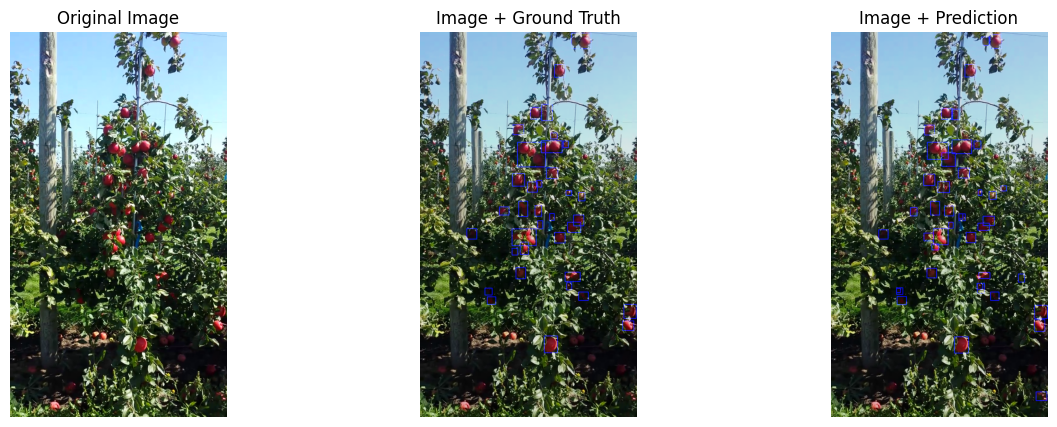

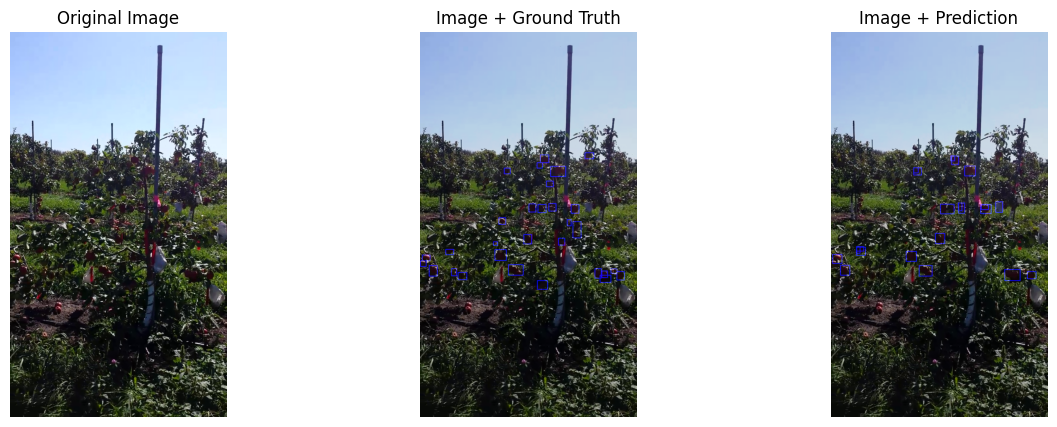

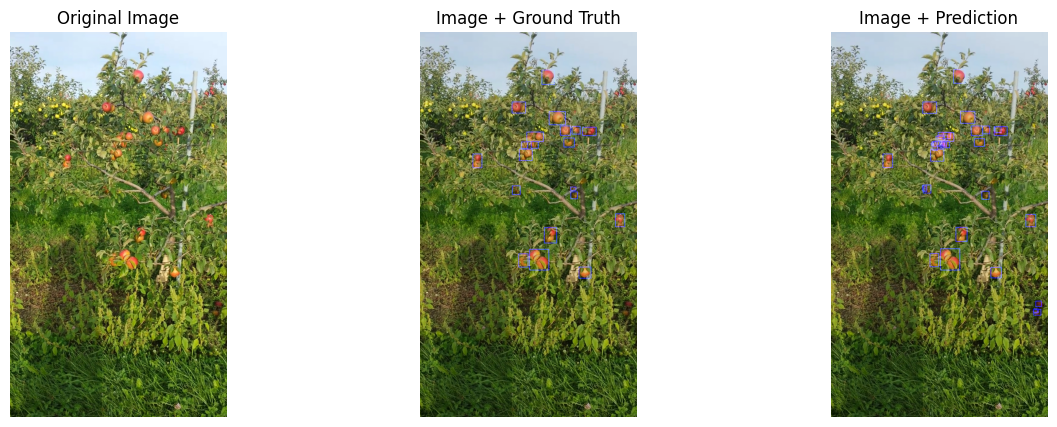

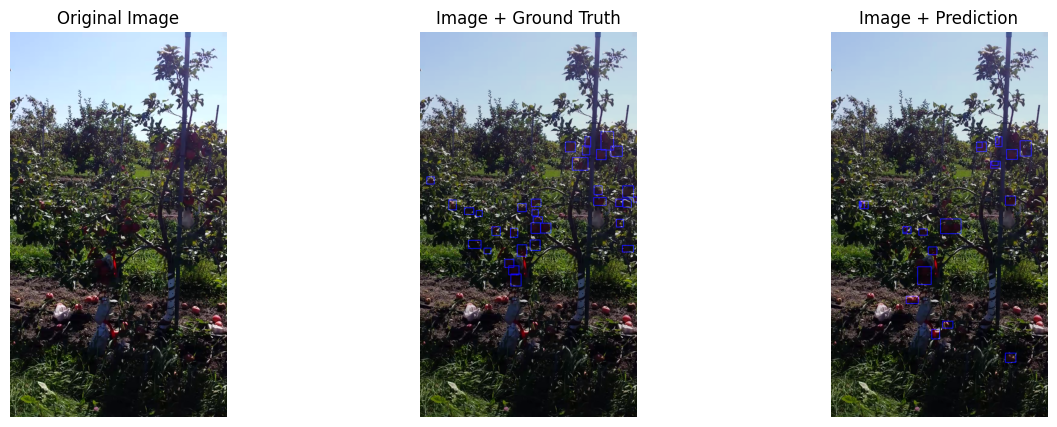

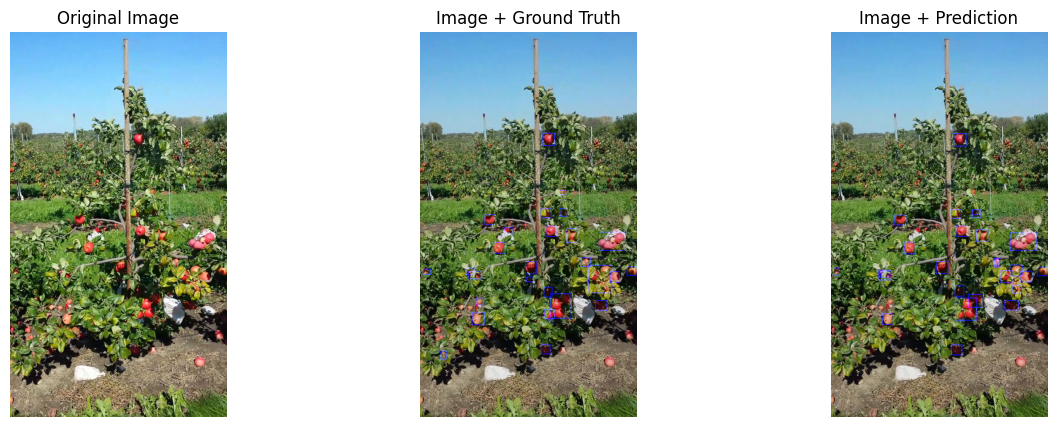

In [33]:
sample_indices = random.sample(range(len(val_imgs)), 5)
sample_val_imgs = [val_imgs[i] for i in sample_indices]
sample_val_mask_gt = [box_gt[i] for i in sample_indices]
sample_val_mask_preds = [box_pred[i] for i in sample_indices]

for img, gt, pred in zip(sample_val_imgs, sample_val_mask_gt, sample_val_mask_preds):
    original_img = cv2.imread(img)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    bbox_gt = np.zeros_like(original_img, dtype=np.uint8)
    bbox_pred = np.zeros_like(original_img, dtype=np.uint8)
    for coord in gt:
        cv2.rectangle(bbox_gt, (int(coord[0]), int(coord[1])), (int(coord[2]), int(coord[3])), (0, 0, 255), 2)
    for bbox in pred:
        coord = bbox[0]
        cv2.rectangle(bbox_pred, (int(coord[0]), int(coord[1])), (int(coord[2]), int(coord[3])), (0, 0, 255), 2)
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))


    axs[0].imshow(original_img)
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    img_n_gt = cv2.addWeighted(original_img, 0.9, bbox_gt, 0.9, 0)
    axs[1].imshow(img_n_gt)
    axs[1].set_title('Image + Ground Truth')
    axs[1].axis('off')

    img_n_pred = cv2.addWeighted(original_img, 0.9, bbox_pred, 0.9, 0)
    axs[2].imshow(img_n_pred)
    axs[2].set_title('Image + Prediction')
    axs[2].axis('off')

    plt.show()

## Metrics

In [34]:
def iou(box1, box2):
    tlx1, tly1, brx1, bry1 = box1
    tlx2, tly2, brx2, bry2 = box2

    xi1 = max(tlx1, tlx2)
    yi1 = max(tly1, tly2)
    xi2 = min(brx1, brx2)
    yi2 = min(bry1, bry2)

    inter_area = max(0, xi2 - xi1 + 1) * max(0, yi2 - yi1 + 1)
    box1_area = (brx1 - tlx1 + 1) * (bry1 - tly1 + 1)
    box2_area = (brx2 - tlx2 + 1) * (bry2 - tly2 + 1)
    union_area = box1_area + box2_area - inter_area

    return inter_area * 1.0 / union_area

In [35]:
def average_precision(gt_boxes, pred_boxes, iou_thresh=0.5):
    pred_boxes = sorted(pred_boxes, key=lambda x: x[1], reverse=True)
    pred_boxes = [box[0] for box in pred_boxes]

    tp = np.zeros(len(pred_boxes))
    fp = np.zeros(len(pred_boxes))
    fn = np.zeros(len(gt_boxes))
    matched_gt = set()

    for i, pred in enumerate(pred_boxes):
        max_iou = 0
        max_gt_idx = -1
        for j, gt in enumerate(gt_boxes):
            iou_score = iou(pred, gt)
            if iou_score > max_iou:
                max_iou = iou_score
                max_gt_idx = j
        
        if max_iou >= iou_thresh and max_gt_idx not in matched_gt:
            tp[i] = 1
            matched_gt.add(max_gt_idx)
        else:
            fp[i] = 1

    for j, gt in enumerate(gt_boxes):
        if j not in matched_gt:
            fn[j] = 1

    cum_tp = np.cumsum(tp)
    cum_fp = np.cumsum(fp)
    precision = cum_tp / (cum_tp + cum_fp)
    recall = cum_tp / len(gt_boxes)

    precision = np.concatenate(([1], precision, [0]))
    recall = np.concatenate(([0], recall, [1]))

    for i in range(len(precision) - 1, 0, -1):
        precision[i - 1] = max(precision[i - 1], precision[i])

    ap = np.sum((recall[1:] - recall[:-1]) * precision[1:])
    return ap, precision, recall, np.cumsum(fp)[-1], np.cumsum(fn)[-1]

In [36]:
def mean_avg_prec(gt, pred, iou_thresh=0.5):
    maps = []
    idx = 0
    for cur_gt, cur_pred in zip(gt, pred):
        if cur_gt and cur_pred:
            ap, prec, rec, fp, fn = average_precision(cur_gt, cur_pred, iou_thresh)
            if idx == 0:
                print("Image 0, IoU threshold = ", iou_thresh)
                print("False positive: ", fp)
                print("False negative: ", fn)
                print("Precision-Recall Curve")
                plt.plot(rec, prec)
                plt.title(f"Precision-Recall Curve - Image 0, IoU threshold {iou_thresh}")
                plt.show()
        else:
            ap = 0.0
        maps.append(ap)
        idx += 1
    return np.mean(maps)

Image 0, IoU threshold =  0.5
False positive:  12.0
False negative:  4.0
Precision-Recall Curve


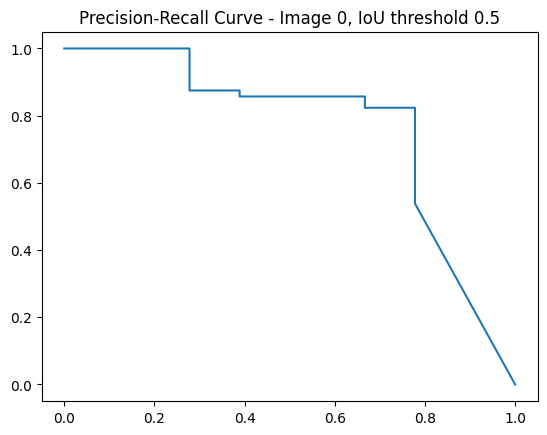

mAP at IoU threshold = 0.5: 0.5858453035536932


Image 0, IoU threshold =  0.6
False positive:  13.0
False negative:  5.0
Precision-Recall Curve


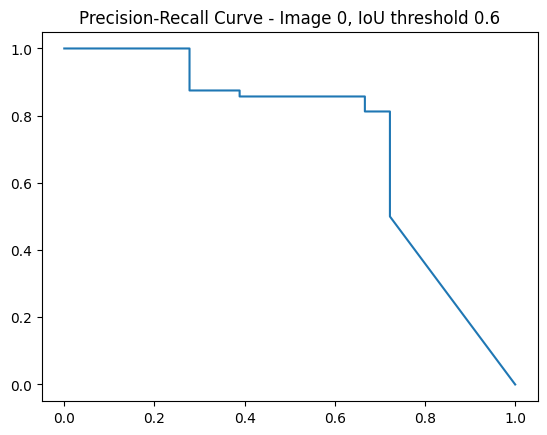

mAP at IoU threshold = 0.6: 0.4725093467002114


Image 0, IoU threshold =  0.7
False positive:  19.0
False negative:  11.0
Precision-Recall Curve


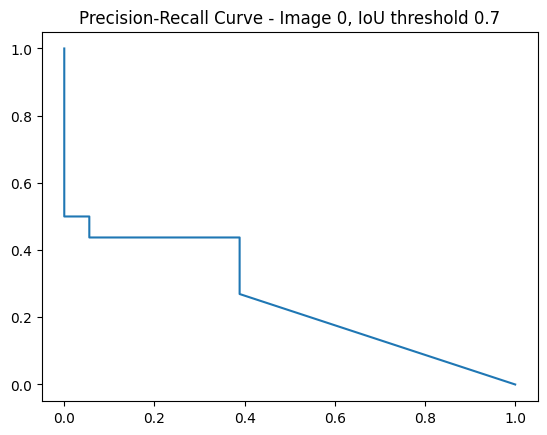

mAP at IoU threshold = 0.7: 0.3080364071755885


Image 0, IoU threshold =  0.8
False positive:  26.0
False negative:  18.0
Precision-Recall Curve


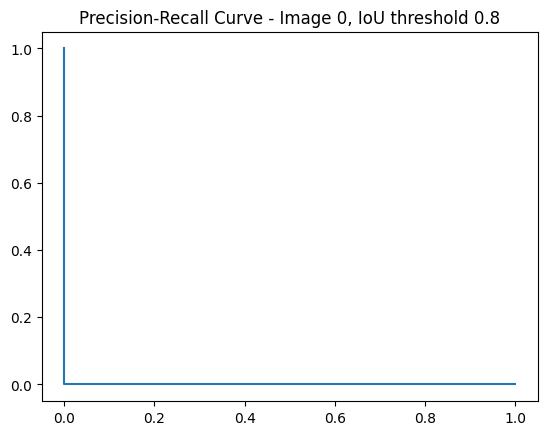

mAP at IoU threshold = 0.8: 0.14703638389824894




In [37]:
for thresh in [0.5, 0.6, 0.7, 0.8]:
    map_score = mean_avg_prec(box_gt, box_pred, thresh)
    print(f"mAP at IoU threshold = {thresh}: {map_score}\n\n")

## External Image

In [47]:
model.load_state_dict(torch.load("model_color_jitter.pth"))

<All keys matched successfully>

In [48]:
external_sample = cv2.imread("sample_fruit_tree.png")
external_sample = cv2.cvtColor(external_sample, cv2.COLOR_BGR2RGB)
external_sample_t = torch.as_tensor(external_sample, dtype=torch.float32).permute(2, 0, 1) / 255.0
external_sample_t = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(external_sample_t)

In [49]:
model.eval()
with torch.no_grad():
    pred = model([external_sample_t])

In [50]:
box_pred = pred[0]['boxes'].numpy()

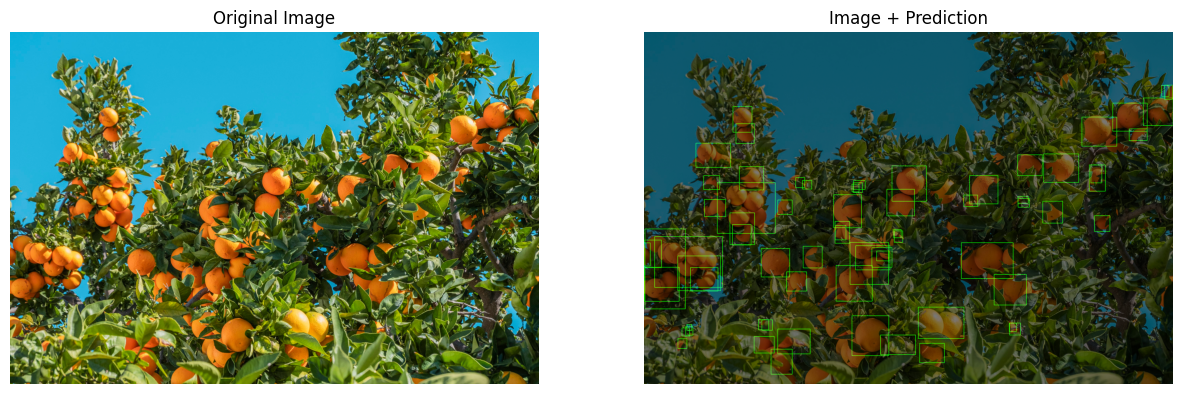

In [58]:
bbox_pred = np.zeros_like(external_sample, dtype=np.uint8)
for coord in box_pred:
    cv2.rectangle(bbox_pred, (int(coord[0]), int(coord[1])), (int(coord[2]), int(coord[3])), (0, 255, 0), 2)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))


axs[0].imshow(external_sample)
axs[0].set_title('Original Image')
axs[0].axis('off')

img_n_pred = cv2.addWeighted(external_sample, 0.5, bbox_pred, 1, 0)
axs[1].imshow(img_n_pred)
axs[1].set_title('Image + Prediction')
axs[1].axis('off')

plt.show()